In [1]:
import torch
import torchvision
import torchvision.transforms as transforms # 
import torchvision.datasets.mnist as mnist  # to import data

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt
import numpy as np

from __future__ import print_function, division
import os
from PIL import Image
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import collections
import torch.nn.init as init

In [5]:
total_nb_of_sample = 9999 # total number of sample per class, this shouldn't be hardcoded
class labeledDataSet(torch.utils.data.Dataset):

    def __init__(self, label, idx_min , idx_max , root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        super(labeledDataSet, self).__init__()
        dic = {"Cat" : int(1) , "Dog" : int(0)}
        
        if dic.get(label , "not found" ) == "not found" :
            raise ValueError("label must either be Cat or Dog")
            
        if idx_max > total_nb_of_sample or idx_min < 0 :
            raise ValueError("min, max index error")
            
        self.label_name = label
        self.idx_min = idx_min
        self.idx_max = idx_max
        self.label = dic[label]
        self.root_dir = root_dir
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor = torch.empty(size,3,64,64,dtype=torch.float)
        self.target_tensor = torch.ones(size,dtype=torch.long) * self.label
        
        for i,j in enumerate(range( self.idx_min , self.idx_max , 1 ),0) :
            img_name = os.path.join(self.root_dir, "{index}.{Label}.jpg".format(index=(j),Label=self.label_name))
            # image = io.imread(img_name)
            # print( i , " : " , io.imread(img_name).shape )
            # img = io.imread(img_name)
            img = Image.open( img_name ).convert('RGB')
            """
            NOTE : There is at least one grey-scale picture of Einstein, manually remove it ?
            the greyscale (1 channel) images have to be converted to 3 channels tensors
            """   
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        # return len(self.name_frame)
        return (self.idx_max - self.idx_min + 1)

    def __getitem__(self, idx):
        return self.data_tensor[idx], self.target_tensor[idx]


Setting the directory of the pictures

In [ ]:
dog_dir = "./data_catdogs/trainset/Dog"
cat_dir = "./data_catdogs/trainset/Cat"

# picture no 1             to (idx_sep)            belong to the training dataset
# picture no (idx_sep + 1) to (total_nb_of_sample) belong to the validation dataset
idx_sep = 8000

trainDogSet = labeledDataSet( "Dog", 1 , idx_sep , root_dir = dog_dir )
trainCatSet = labeledDataSet( "Cat", 1 , idx_sep , root_dir = cat_dir )

testsDogSet = labeledDataSet( "Dog", idx_sep + 1 , total_nb_of_sample , root_dir = dog_dir )
testsCatSet = labeledDataSet( "Cat", idx_sep + 1 , total_nb_of_sample , root_dir = cat_dir )

In [6]:
trainset = torch.utils.data.ConcatDataset( [ trainDogSet , trainCatSet ] )
testsset = torch.utils.data.ConcatDataset( [ testsDogSet , testsCatSet ] )

In [7]:
testing_dataset_size  = testsCatSet.__len__() + testsDogSet.__len__()
training_dataset_size = trainCatSet.__len__() + trainDogSet.__len__()

print( "training dataset size = " , training_dataset_size ) 
print( "testing  dataset size = " , testing_dataset_size ) 
print( trainDogSet.__doc__ ) 
img, label =  trainDogSet.__getitem__(1)
print( "img size = " , img.size() , "label size = " , label.size() )

training dataset size =  16000
testing  dataset size =  3998
None
img =  torch.Size([3, 64, 64]) label =  torch.Size([])


Display some samples

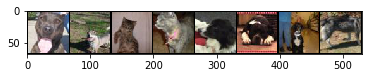

    0     0     1     1     0     0     0     0


In [8]:
nb_sample = 8

trainloader = torch.utils.data.DataLoader(trainset , batch_size = nb_sample,  shuffle=True , num_workers=0)
testsloader  = torch.utils.data.DataLoader(testsset , batch_size = nb_sample, shuffle=True , num_workers=0)

# functions to show an image

def imshow(img):
    npimg = img.numpy() / 255
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter( testsloader )
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(nb_sample)))

set the device

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## The model 
architecture taken from : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [10]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz = 3 ):
        
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad ),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # 
        self.fct = nn.Linear(4*4*128, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4*4*128)
        x = torch.sigmoid(self.fct(x))
        # x = self.fct(x)
        # x = F.softmax(self.fct(x),dim=-1)
        return x

Print the number of parameters in each models and display the computation 

In [11]:
def number_of_params( net ) :
    nb_param  = 0
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    print( "number of params = " , nb_param , " = ", param_lst  )

mytestnet = Classifier( kernel_sz=9 )
number_of_params( mytestnet )
del mytestnet

number of params =  877089  =   
 (conv.0.weight)          16*3*9*9
 (conv.0.bias)          + 16
 (conv.3.weight)        + 32*16*9*9
 (conv.3.bias)          + 32
 (conv.6.weight)        + 64*32*9*9
 (conv.6.bias)          + 64
 (conv.9.weight)        + 128*64*9*9
 (conv.9.bias)          + 128
 (fct.weight)           + 1*2048
 (fct.bias)             + 1


init method

In [12]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)

In [33]:
if True :
    del cudanet

In [34]:
cudanet = Classifier( kernel_sz = 9 )
cudanet.apply( glorot_init )
cudanet.to(device)

Classifier(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fct): Linear(in_features=2048, out_features=1, bias=True)
)

In [36]:
criterion = nn.BCELoss() # Binary Cross Entropy 
optimizer = optim.SGD(cudanet.parameters(), lr=0.0001, momentum=0.0, weight_decay=0)
nb_epoch  = 30

In [37]:
if False :
    print( cudanet( torch.ones(1,3,64,64).to(device) ) )
    print( cudanet( torch.ones(1,3,64,64).to(device) ).dtype )

    with torch.no_grad() :
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cudanet(inputs).squeeze()
            print( outputs.size() , labels.size() )
            print( outputs )
            loss = criterion(outputs, labels)
            print( loss )

            break

## Training the model  

Note : 30 epoch with lr=0.0001 are not enough, add more epoch, larger lr could be an issue for fine tuning the model

In [39]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4*64,shuffle=True, num_workers=0)
state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for epoch in range( nb_epoch ):  # loop over the dataset multiple times 
        
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.float()
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cudanet(inputs).squeeze()
        # if i == 0 : print( outputs )
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    else : # print every epoch
        print('epoch = %d, loss = %.8f' % (epoch + 1, running_loss / (i*8*64))) # nb of sample per mini-batch
        running_loss = 0.0
        torch.cuda.synchronize()
        tmp_state_dict = {}
        for k, v in cudanet.state_dict().items():
            tmp_state_dict[k] = v.cpu()
        state_dict_list.append( tmp_state_dict )
        torch.cuda.synchronize()
        
else : 
    print('Finished Training')
    
end.record()
torch.cuda.synchronize()
print( "time required = " , start.elapsed_time(end)*0.001 , " s ")

epoch = 1, loss = 0.00791041
epoch = 2, loss = 0.00150025
epoch = 3, loss = 0.00140869
epoch = 4, loss = 0.00135263
epoch = 5, loss = 0.00131762
epoch = 6, loss = 0.00128026
epoch = 7, loss = 0.00126457
epoch = 8, loss = 0.00125376
epoch = 9, loss = 0.00122598
epoch = 10, loss = 0.00122030
epoch = 11, loss = 0.00119520
epoch = 12, loss = 0.00118546
epoch = 13, loss = 0.00117974
epoch = 14, loss = 0.00116469
epoch = 15, loss = 0.00115254
epoch = 16, loss = 0.00115322
epoch = 17, loss = 0.00114271
epoch = 18, loss = 0.00113528
epoch = 19, loss = 0.00112319
epoch = 20, loss = 0.00111661
epoch = 21, loss = 0.00110833
epoch = 22, loss = 0.00110505
epoch = 23, loss = 0.00109424
epoch = 24, loss = 0.00109197
epoch = 25, loss = 0.00107874
epoch = 26, loss = 0.00108290
epoch = 27, loss = 0.00107191
epoch = 28, loss = 0.00106411
epoch = 29, loss = 0.00106355
epoch = 30, loss = 0.00104832
Finished Training
time required =  366.51428125  s 


#### test accuracy of the current state on validation dataset

In [29]:
testsloader = torch.utils.data.DataLoader(testsset, batch_size=8*64,shuffle=False, num_workers=0)
correct = torch.tensor([0])
total = torch.tensor([0])

correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in testsloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cudanet(images).squeeze()
        predicted = torch.where(
                        outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) 
                    )
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , testing_dataset_size , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 

Accuracy of the network on the 3998 test images: 70.19 %


#### accuracy across epoch

In [40]:
trainloader = torch.utils.data.DataLoader(trainset , batch_size = 8*64 , shuffle=False , num_workers=0)
testsloader = torch.utils.data.DataLoader(testsset , batch_size = 8*64, shuffle=False , num_workers=0)

accuracy = torch.ones(nb_epoch,2, dtype=torch.float) * 100
for epoch , tmp_state_dict in enumerate(state_dict_list,0) :
    if epoch % 1 != 0 :
        continue
    
    cudaTOCPUnet = copy.deepcopy( cudanet )
    cudaTOCPUnet.load_state_dict( tmp_state_dict )
    cuda_test_net = copy.deepcopy(cudaTOCPUnet).to(device)
    
    correct = torch.tensor([0,0])
    total   = torch.tensor([0,0])
    
    correct, total = correct.to(device) , total.to(device) 
        
    loader_list = [ testsloader , trainloader ]
    with torch.no_grad():
        for i, loader in enumerate(loader_list,0) :
            for data in loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = cuda_test_net(images).squeeze()
                predicted = torch.where(
                                outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) 
                            )
                total[i] += labels.size(0)
                correct[i] += (predicted == labels).sum()
    
    accuracy[epoch,:] = accuracy[epoch,:] * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
    
    print('epoch %3d : Accuracy of the network on the test images: %.2f %% , training images %.2f %% ' 
              % ( epoch+1, accuracy[epoch,0] , accuracy[epoch,1] )
         )

epoch   1 : Accuracy of the network on the test images: 54.23 % , training images 55.58 % 
epoch   2 : Accuracy of the network on the test images: 55.85 % , training images 56.51 % 
epoch   3 : Accuracy of the network on the test images: 61.83 % , training images 61.86 % 
epoch   4 : Accuracy of the network on the test images: 61.56 % , training images 61.91 % 
epoch   5 : Accuracy of the network on the test images: 64.66 % , training images 64.74 % 
epoch   6 : Accuracy of the network on the test images: 63.78 % , training images 64.81 % 
epoch   7 : Accuracy of the network on the test images: 64.88 % , training images 65.60 % 
epoch   8 : Accuracy of the network on the test images: 65.48 % , training images 66.20 % 
epoch   9 : Accuracy of the network on the test images: 65.71 % , training images 67.39 % 
epoch  10 : Accuracy of the network on the test images: 65.96 % , training images 67.42 % 
epoch  11 : Accuracy of the network on the test images: 66.33 % , training images 68.41 % 

### Plot accuracy

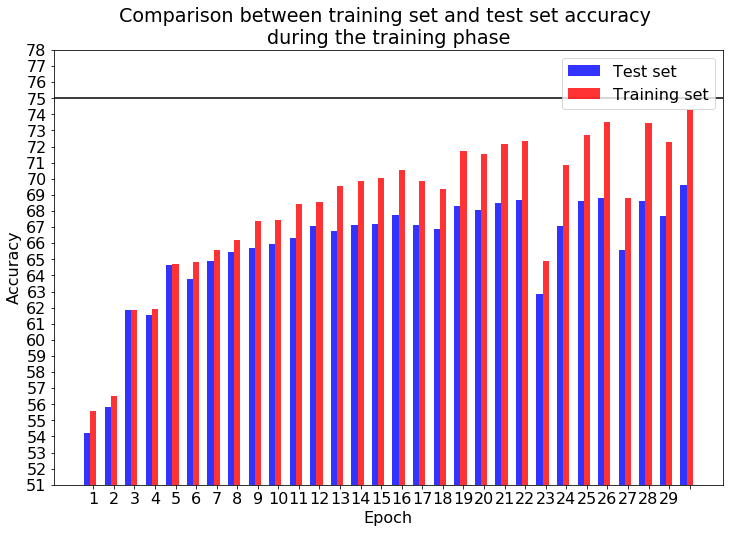

In [43]:
from matplotlib.pyplot import figure
# import warnings
# warnings.filterwarnings('ignore')

# data to plot
n_groups = nb_epoch
accuracy_toplot = accuracy.numpy()

tests_accuracy = accuracy_toplot[:,0]
train_accuracy = accuracy_toplot[:,1]

#
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12 ,8)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, tests_accuracy, bar_width,
                 alpha=opacity,
                 color='blue',
                 label='Test set')
 
rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Training set')

eps = 3 
top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


plt.ylim(bot, top)     # set the ylim to bottom, top
plt.axhline(y=75,color="black")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison between training set and test set accuracy \nduring the training phase')
plt.xticks(index + bar_width, range(1,n_groups,1) )
plt.yticks( range(bot,top+1,1) )
plt.legend()

# plt.tight_layout()
plt.show()

# Misc

#### print some test sample that the net misclassifies

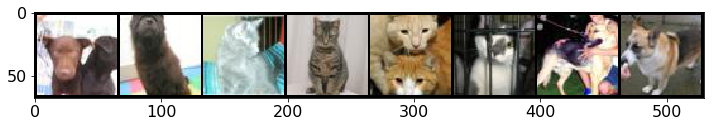

Probabilities goes from : 0 -> this is a dog for sure , to 1 -> cat for sure
this should be          :   0   , 0   , 1   , 1   , 1   , 1   , 0   , 0   
net associated prob     :   0.60, 0.85, 0.47, 0.25, 0.14, 0.41, 0.54, 0.76


In [60]:
testsloader = torch.utils.data.DataLoader(testsset , batch_size = 8*64, shuffle=True , num_workers=0)

nb_of_error = torch.tensor([8])
j = torch.tensor([0])
errorimages  = torch.empty(8,3,64,64)
errorlabels  = torch.empty(8)
erroroutputs = torch.empty(8)
for images, labels in testsloader :
    images, labels = images.to(device), labels.to(device)
    outputs = cuda_test_net(images).squeeze()
    predicted = torch.where(
                    outputs > 0.5, torch.ones_like(labels, device=device) , torch.zeros_like(labels, device=device) 
                    )
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j] = outputs[i].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break
        
if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )
    
    print( "Probabilities goes from : 0 -> this is a dog for sure , to 1 -> cat for sure")
    print( "this should be          : " , ",".join( " %-4d" % nb.item() for nb in errorlabels ) ) 
    print( "net associated prob     : " , ",".join( "%5.2f" % nb.item() for nb in erroroutputs ) ) 

### Save and load models

#### Save the state_dict of the model for each epoch on a local directory

In [57]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)
    # print( saving_path )

./save/dev1num3model_for_epoch1.pth
./save/dev1num3model_for_epoch2.pth
./save/dev1num3model_for_epoch3.pth
./save/dev1num3model_for_epoch4.pth
./save/dev1num3model_for_epoch5.pth
./save/dev1num3model_for_epoch6.pth
./save/dev1num3model_for_epoch7.pth
./save/dev1num3model_for_epoch8.pth
./save/dev1num3model_for_epoch9.pth
./save/dev1num3model_for_epoch10.pth
./save/dev1num3model_for_epoch11.pth
./save/dev1num3model_for_epoch12.pth
./save/dev1num3model_for_epoch13.pth
./save/dev1num3model_for_epoch14.pth
./save/dev1num3model_for_epoch15.pth
./save/dev1num3model_for_epoch16.pth
./save/dev1num3model_for_epoch17.pth
./save/dev1num3model_for_epoch18.pth
./save/dev1num3model_for_epoch19.pth
./save/dev1num3model_for_epoch20.pth
./save/dev1num3model_for_epoch21.pth
./save/dev1num3model_for_epoch22.pth
./save/dev1num3model_for_epoch23.pth
./save/dev1num3model_for_epoch24.pth
./save/dev1num3model_for_epoch25.pth
./save/dev1num3model_for_epoch26.pth
./save/dev1num3model_for_epoch27.pth
./save/dev

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num3model_for_epoch{j}.pth" for j from ... to ...

In [59]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx   = nb_epoch

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num3model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    # print( path )
else : 
    cudanet = Classifier( kernel_sz = 9 )
    cudanet.load_state_dict(tmp_dict)
    cudanet.to(device)
    cudanet.eval()                     